In [1]:
import pandas as pd
from os import path

import_directory = "synData6July"
lotti_fn = "export_lotti_veneto_2016_2018_giulio_v2.csv"
vincitori_fn = "export_vincitori_veneto_2016_2018_giulio_v2.csv"
output_directory = "datasets"

def replace_missing_value(df, col, replacement_col):
    mask = df[replacement_col].notna() & df[col].isna()
    df.loc[df[mask].index, col] = df[replacement_col][mask]
    return df

lotti = pd.read_csv(
        path.join(import_directory, lotti_fn))
vincitori = pd.read_csv(
        path.join(import_directory, vincitori_fn))

# convert datatypes
lotti.data_inizio = pd.to_datetime(lotti.data_inizio, yearfirst=True)
lotti.data_fine = pd.to_datetime(lotti.data_fine, yearfirst=True)
lotti.data_inferita = pd.to_datetime(lotti.data_inferita, yearfirst=True)

# replace missing values in col1 with values from col2
lotti = replace_missing_value(lotti, "importo", "importo_base_asta")
lotti = replace_missing_value(lotti, "data_inizio", "data_inferita")

# voglio che solo i lotti a cui sia stato assegnato un vincitore siano presenti
df = vincitori.merge(lotti, on="id_lotto", how="left")

In [2]:
party = vincitori.groupby("id_lotto").size().rename("party")

In [3]:
df = df.merge(party, on="id_lotto", how="left")

In [4]:
# dividi l'importo per il numero di parti
df.loc[:, "importo"] = df.importo / df.party

In [5]:
# CONSIDER ONLY THE ROWS THAT HAVE CPV AND PROCEDURE NOTNA
df = df[df.cpv.notna()]
df = df[df.id_scelta_contraente.notna()]

In [6]:
t = df.groupby([df.data_inizio.dt.year, df.id_be]).size().rename("n_lots")
t

data_inizio  id_be  
2016         19         5
             33         1
             63         6
             111        3
             142        3
                       ..
2018         3416616    2
             3439739    1
             3439742    1
             3439817    3
             3439820    3
Name: n_lots, Length: 135996, dtype: int64

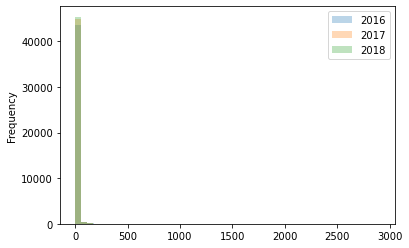

In [7]:
import matplotlib.pyplot as plt
for i, year in enumerate([2016, 2017, 2018]):
    t[year].plot.hist(bins=50, alpha=.3, label=year)
plt.legend()
plt.show()

7 contracts s.t. perc >= 0.7 in 2016
7 contracts s.t. perc >= 0.7 in 2017
8 contracts s.t. perc >= 0.7 in 2018


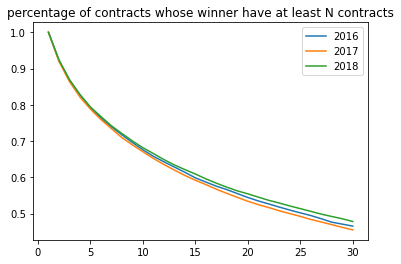

In [9]:
import numpy as np
N = 30
x = np.arange(1, N+1)
threshold = .7
for year in [2016, 2017, 2018]:
    y = np.zeros(x.size)
    for i, n in enumerate(x):
        perc = sum(t[year][t[year] >= n]) / sum(t[year])
        y[i] = perc
    plt.plot(x, y, label=year)
    n = sum(y>=threshold)
    print(f"{n-1} contracts s.t. perc >= {threshold} in {year}")
plt.legend()
plt.title("percentage of contracts whose winner have at least N contracts")
plt.show()

ma si massimizza il numero di aziende o di contratti? coincidono le cose? No, 
ci sono poche aziende che chiudono moltissimi contratti

lost be perc 0.86, year 2016
lost be perc 0.86, year 2017
lost be perc 0.86, year 2018


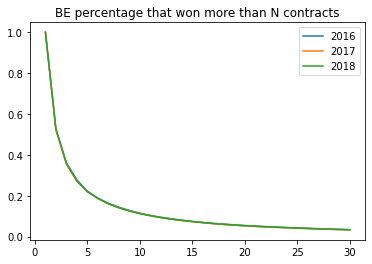

In [11]:
N = 30
x = np.arange(1, N+1)
import matplotlib.pyplot as plt
for i, year in enumerate([2016, 2017, 2018]):
    y = np.zeros(x.size)
    for i, n in enumerate(x):
        perc = sum(t[year] >= n) / len(t[year])
        y[i] = perc
    plt.plot(x, y, label=year)
    print(f"lost be perc {1 - y[7] :.2f}, year {year}")
plt.legend()
plt.title("BE percentage that won more than N contracts")
plt.show()